> Mathematical Engineering and Physics using Machine Learning, EE798Z

##### *November 25th, 2024*

## Course Project - Wind Power Forecasting

**Kartik Anant Kulkarni (Roll no. 210493)**


----



# Phase 1 - Data Analysis, Baseline and Initial Approach

## Settings
1. Please setup the environment as per the requirements with appropriate package versions.
2. As the notebook uses interactive widgets, to fully see and understand all the outputs, it is better to run the notebook before going through the outputs.

## Imports

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from ipywidgets import interact, interact_manual, fixed
from typing import List, Iterable, Tuple, Dict, Optional, Callable

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.inspection import permutation_importance

import tensorflow as tf
from dataclasses import dataclass
import pickle

## Configuration

In [2]:
FONT_SIZE_TICKS = 15
FONT_SIZE_TITLE = 25
FONT_SIZE_AXES = 20

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [4]:
SDWPF_RAW_PATH = "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_2001_2112_full.csv"
TURBINE_LOC_PATH = (
    "./../Datasets/SDWPF_dataset/sdwpf_full/sdwpf_turb_location_elevation.csv"
)
OPEN_WEATHER_FORECASTS = "./../Datasets/wind_speed_analysis/weather_forecast.pkl"
IMAGES_DIR = "./../output"

## Dataset

The raw dataset has the following time series features. The target variable is active power.
| Column Name | Specification Note |
| --- | --- |
| TurbID | Wind turbine ID |
| Tmstamp | Created time of the record Time zone UTC + 08:00 |
| Wspd (m/s) | The wind speed at the top of the turbine Recorded by mechanical anemometer |
| Wdir(°) | Relative wind direction, which is the angle between the wind direction and the the turbine nacelle direction. Wind  direction and nacelle direction are in degrees from true north |
| Etmp | Temperature of the surrounding environment Measured outer surface of the nacelle |
| Itmp | Temperature inside the turbine nacelle |
| Ndir (°) | Nacelle direction, the yaw angle of the nacelle In degree from true north |
| Pab1 (°) | Pitch angle of blade 1 The angle between the chord line and the rotation plane of the blade |
| Pab2 (°) | Pitch angle of blade 2 Same as above |
| Pab3 (°) | Pitch angle of blade 3 Same as above |
| Prtv (kW) | Reactive power |
| T2m | Temperature at 2 m above surface (ERA5) |
| Sp (Pa) | Surface pressure from ERA5 |
| RelH | Relative humidity Derived based on 2 m dew point temperature and 2m temperature using Python Package metpy |
| Wspd_w (m/s) | Wind speed from ERA5 At height of 10 m |
| Wdir_w (°) | Wind direction from ERA5 At height of 10 m |
| Tp (m) | Total precipitation from ERA5 |
| Patv (kW) | Active power, the wind power produced by a wind turbine |
<!-- | Day | Day of the record | -->

The new data also has the geolocations of each turbines with the elevations.

In [5]:
raw_data = pd.read_csv(SDWPF_RAW_PATH)
raw_data.head(5)

TurbID              Tmstamp   Wspd   Wdir   Etmp    Itmp    Ndir   Pab1  \
0      57  2020-01-03 04:25:00  7.935  0.055  2.185  23.415  236.59 -0.840   
1      57  2020-01-03 04:55:00  6.425 -1.860  2.945  23.550  236.59 -0.610   
2      57  2020-01-03 05:25:00  5.945 -1.635  3.720  23.350  236.59 -0.435   
3      57  2020-01-03 05:55:00  6.290  1.220  4.385  23.285  236.59 -0.510   
4      57  2020-01-03 06:25:00  5.650  3.790  4.945  23.265  243.84 -0.355   

    Pab2   Pab3    Prtv        T2m         Sp      RelH    Wspd_w     Wdir_w  \
0 -0.840 -0.845  29.680 -12.312683  85893.516  0.529154  5.191925  52.389540   
1 -0.605 -0.610  14.480 -12.312683  85893.516  0.529154  5.191925  52.389540   
2 -0.435 -0.435  15.270 -11.709015  85836.430  0.516070  5.563238  56.420248   
3 -0.510 -0.510  19.030 -11.709015  85836.430  0.516070  5.563238  56.420248   
4 -0.355 -0.355   9.795 -10.475830  85820.766  0.515158  6.000677  55.780818   

    Tp     Patv  
0  0.0  976.925  
1  0.0  610.830  
2  0.0  483.850  
3  0.0  536.970  
4  0.0  431.700

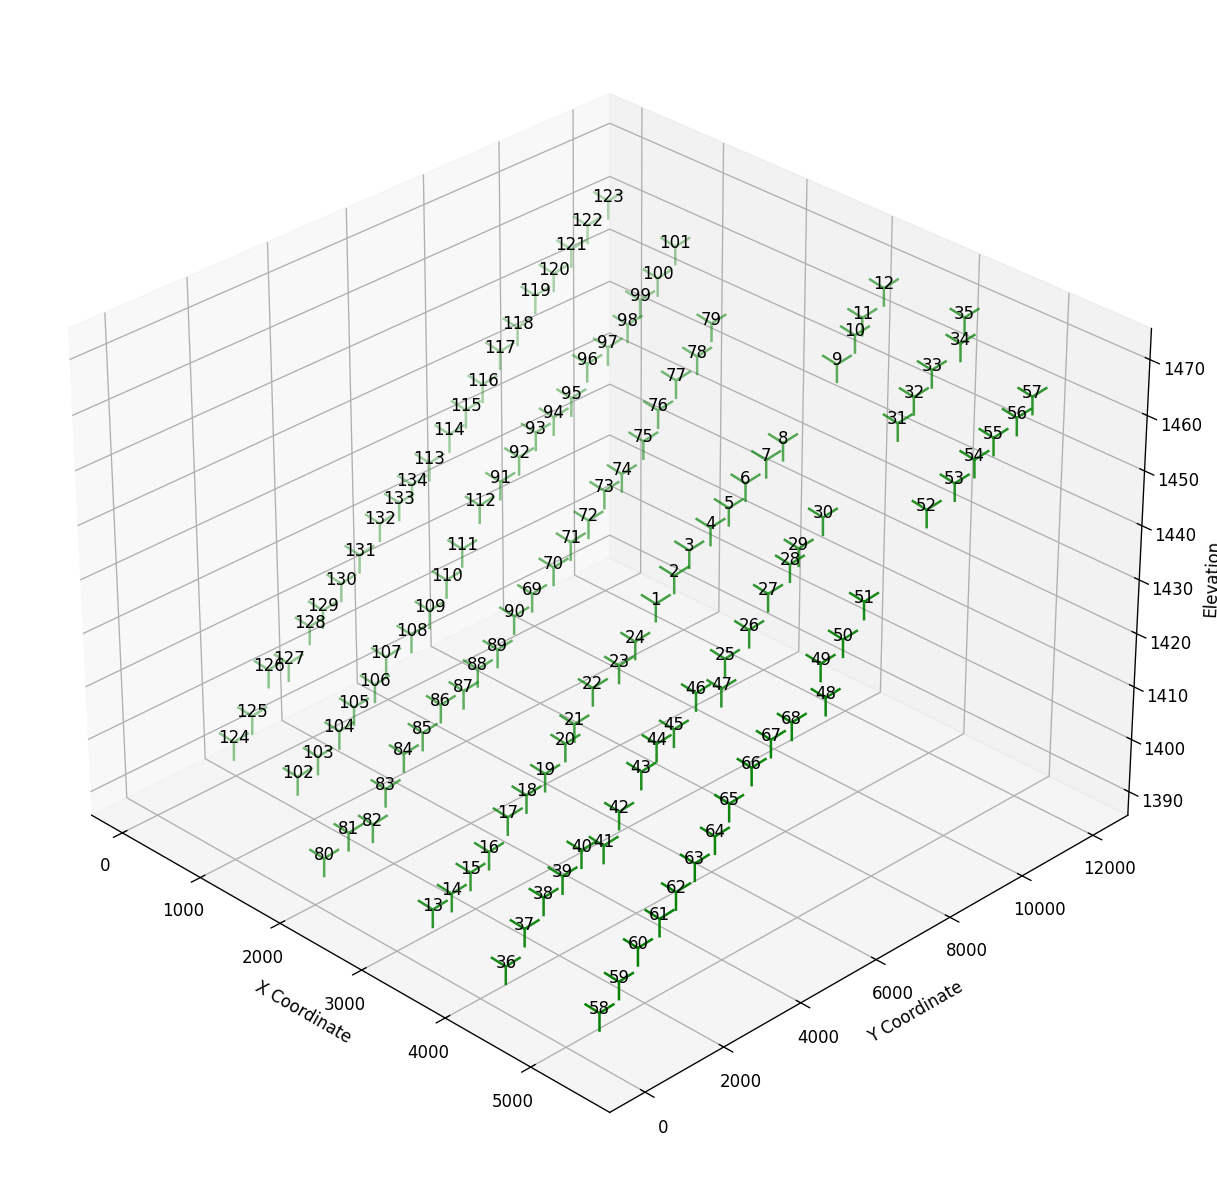

In [6]:
def plot_turbines(raw_data: pd.core.frame.DataFrame):
    """Plot turbines' relative positions.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset used.
    """
    turb_locations = pd.read_csv(TURBINE_LOC_PATH)
    turbs = turb_locations[turb_locations.TurbID.isin(raw_data.TurbID.unique())]
    turbs = turbs.reset_index()
    n = list(raw_data.TurbID.unique())

    x = turbs["x"]
    y = turbs["y"]
    z = turbs["Ele"]

    # Create the plot
    fig = plt.figure(figsize=(10, 10), dpi=120)
    ax = fig.add_subplot(111, projection="3d")

    # # Assign colors for each data point based on the id or any other feature
    # colors = np.random.rand(len(turbs))  # Random color for each point

    # Plot the points (coloring them)
    scatter = ax.scatter(x, y, z, c="green", s=500, marker="1")

    # Label each point with its ID
    for i in range(len(turbs)):
        ax.text(
            x[i],
            y[i],
            z[i],
            f'{turbs["TurbID"][i]}',
            color="black",
            fontsize=10,
            ha="center",
        )

    # Set labels for axes
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")
    ax.set_zlabel("Elevation")

    # Rotate the plot about the z-axis (azim controls the rotation)
    ax.view_init(azim=-45)  # Adjust `azim` for rotation

    plt.tight_layout()
    plt.show()
    fig.savefig(IMAGES_DIR + "/turbine_loc_3d.png", pad_inches=1, bbox_inches="tight")


plot_turbines(raw_data)

### Missing Values

Some values at some time are not collected from the SCADA system. Filling the
missing values with with next values is better than interpolation. The
interpolation method is linear interpolation and the effect is not as good as
the other method. In terms of correlation, the correlation between wind speed
and wind power is the highest, which is about 0.814801. However, wind speed
does not change linearly, so linear interpolation is not suitable to fill the
missing value.

In [7]:
print("Number of missing values per column:\n")
print(raw_data.isnull().sum())

mv = raw_data[raw_data.isnull().any(axis=1)]
num_na_values, total_values = len(mv), len(raw_data)
print(
    f"\nThe dataset contains {total_values} rows, of which {num_na_values} are missing.\n\nThis is {(num_na_values/total_values)*100:.3f}% of the total data."
)

Number of missing values per column:

TurbID          0
Tmstamp         0
Wspd       496998
Wdir       496998
Etmp       496998
Itmp       496998
Ndir       496998
Pab1       496998
Pab2       496998
Pab3       496998
Prtv       496998
T2m          4288
Sp           4288
RelH         4288
Wspd_w       4288
Wdir_w       4288
Tp           4288
Patv       496998
dtype: int64

The dataset contains 11361190 rows, of which 496998 are missing.

This is 4.375% of the total data.


In [8]:
raw_data["Tmstamp"] = pd.to_datetime(raw_data["Tmstamp"])
raw_data.sort_values(by=["Tmstamp", "TurbID"], inplace=True)

# Backward fill missing values (NANs), i.e. the missing value is substituted with the next available value
raw_data = raw_data.bfill()
# For the rest of the values drop the corresponding entries
raw_data = raw_data.dropna()

print("Number of missing values per feature:\n")
print(raw_data.isnull().sum())

Number of missing values per feature:

TurbID     0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
T2m        0
Sp         0
RelH       0
Wspd_w     0
Wdir_w     0
Tp         0
Patv       0
dtype: int64


### Visualise

1. Histograms
2. Box Plots and Violin Plots
3. Scatterplots
4. Pairplots
5. Correlaton Matrix
6. Time Series (for single and pair of turbines)

In [9]:
numerical_features = [
    f for f in list(raw_data.columns) if f not in ["TurbID", "Day", "Tmstamp"]
]
descriptive_stats = raw_data[numerical_features].describe()
descriptive_stats.apply(lambda s: s.apply("{0:.3f}".format))

Wspd          Wdir          Etmp          Itmp          Ndir  \
count  11360922.000  11360922.000  11360922.000  11360922.000  11360922.000   
mean          4.937         1.154        27.668        24.475       168.231   
std           3.486        32.809        64.349        19.276       170.842   
min           0.000     -1075.040      -273.170      -273.170     -1083.700   
25%           2.110        -3.400         7.255        16.440        41.960   
50%           4.140        -0.220        18.870        25.230       178.860   
75%           7.010         3.350        30.010        34.830       303.100   
max          56.870       842.140       394.330       324.210       700.630   

               Pab1          Pab2          Pab3          Prtv           T2m  \
count  11360922.000  11360922.000  11360922.000  11360922.000  11360922.000   
mean         27.037        27.024        27.021        -9.313         9.246   
std          39.071        39.057        39.056        63.059        13.746   
min         -10.000       -10.000       -10.000      -734.880       -22.302   
25%           0.010         0.010         0.010       -21.660        -2.270   
50%           0.330         0.330         0.330        -0.300        10.100   
75%          85.310        85.250        85.270         0.000        20.953   
max          99.980        99.980        99.980       500.310        37.662   

                 Sp          RelH        Wspd_w        Wdir_w            Tp  \
count  11360922.000  11360922.000  11360922.000  11360922.000  11360922.000   
mean      85431.534         0.336         4.877       165.715         0.000   
std         637.330         0.183         2.452       108.270         0.000   
min       83845.830         0.025         0.037         0.008         0.000   
25%       84930.400         0.191         3.152        71.553         0.000   
50%       85378.625         0.298         4.403       117.353         0.000   
75%       85925.250         0.452         6.338       267.490         0.000   
max       87489.220         0.988        16.113       359.984         0.002   

               Patv  
count  11360922.000  
mean        360.687  
std         434.937  
min          -9.310  
25%          -0.300  
50%         172.140  
75%         588.735  
max        1561.380

For visualisation select top 10 turbines.

In [10]:
def top_n_turbines(
    raw_data: pd.core.frame.DataFrame, n: int
) -> pd.core.frame.DataFrame:
    """Keeps only the top n turbines that produced more energy on average.

    Args:
        raw_data (pd.core.frame.DataFrame): The full dataset.
        n (int): Desired number of turbines to keep.

    Returns:
        pd.core.frame.DataFrame: The dataset with only the data from the top n turbines.
    """
    sorted_patv_by_turbine = (
        raw_data.groupby("TurbID")
        .mean(numeric_only=True)["Patv"]
        .sort_values(ascending=False)
    )
    top_turbines = list(sorted_patv_by_turbine.index)[:n]
    print(
        f"Original data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines.\n"
    )
    raw_data = raw_data[raw_data["TurbID"].isin(top_turbines)]
    print(
        f"Sliced data has {len(raw_data)} rows from {len(raw_data.TurbID.unique())} turbines."
    )
    return raw_data


top_turbines = top_n_turbines(raw_data, 10)

Original data has 11360922 rows from 134 turbines.

Sliced data has 847830 rows from 10 turbines.


In [11]:
def histogram_plot(df: pd.core.frame.DataFrame, features: List[str], bins: int = 16):
    """Create interactive histogram plots.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.
        features (List[str]): List of features to include in the plot.
        bins (int, optional): Number of bins in the histograms. Defaults to 16.
    """

    def _plot(turbine, feature):
        data = df[df.TurbID == turbine]
        plt.figure(figsize=(8, 5))
        x = data[feature].values
        plt.xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        sns.histplot(x, bins=bins)
        plt.ylabel(f"Count", fontsize=FONT_SIZE_AXES)
        plt.title(f"Feature: {feature} - Turbine: {turbine}", fontsize=FONT_SIZE_TITLE)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(), value=df.TurbID.unique()[-1], description="Turbine"
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    interact(_plot, turbine=turbine_selection, feature=feature_selection)


bin_size = 64
histogram_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine', index=9, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), val…

In [12]:
def histogram_comparison_plot(
    df: pd.core.frame.DataFrame, features: List[str], bins: int = 16
):
    """Create interactive histogram plots.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.
        features (List[str]): List of features to include in the plot.
        bins (int, optional): Number of bins in the histograms. Defaults to 16.
    """

    def _plot(turbine1, turbine2, feature):
        data_1 = df[df.TurbID == turbine1]
        data_2 = df[df.TurbID == turbine2]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))

        x_1 = data_1[feature].values
        x_2 = data_2[feature].values

        ax1.set_xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax2.set_xlabel(f"{feature}", fontsize=FONT_SIZE_AXES)

        ax1.set_ylabel(f"Count", fontsize=FONT_SIZE_AXES)
        ax2.set_ylabel(f"Count", fontsize=FONT_SIZE_AXES)

        sns.histplot(x_1, bins=bins, ax=ax1)
        sns.histplot(x_2, bins=bins, ax=ax2, color="green")

        ax1.set_title(f"Turbine: {turbine1}", fontsize=FONT_SIZE_TITLE)
        ax1.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        ax2.set_title(f"Turbine: {turbine2}", fontsize=FONT_SIZE_TITLE)
        ax2.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        fig.tight_layout()
        fig.show()

    turbine_selection1 = widgets.Dropdown(
        options=df.TurbID.unique(),
        value=df.TurbID.unique()[-2],
        description="Turbine ID",
        style={"description_width": "initial"},
    )

    turbine_selection2 = widgets.Dropdown(
        options=df.TurbID.unique(),
        value=df.TurbID.unique()[-1],
        description="Another Turbine ID",
        style={"description_width": "initial"},
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    interact(
        _plot,
        turbine1=turbine_selection1,
        turbine2=turbine_selection2,
        feature=feature_selection,
    )


bin_size = 32
histogram_comparison_plot(top_turbines, numerical_features, bin_size)

interactive(children=(Dropdown(description='Turbine ID', index=8, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), …

In [13]:
def box_violin_plot(df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive violin/box plots for the dataset.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        features (List[str]): List of features to include in the plot.
    """
    labels = df["TurbID"].unique()

    def _plot(feature="Wspd", plot_type="box"):
        plt.figure(figsize=(18, 8))
        scale = "linear"
        plt.yscale(scale)
        if plot_type == "violin":
            sns.violinplot(
                data=df, y=feature, x="TurbID", order=labels, color="seagreen"
            )
        elif plot_type == "box":
            sns.boxplot(data=df, y=feature, x="TurbID", order=labels, color="seagreen")
        plt.title(f"Feature: {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel(f"TurbID", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        plt.show()

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    plot_type_selection = widgets.Dropdown(
        options=["violin", "box"], description="Plot Type"
    )

    interact(_plot, feature=feature_selection, plot_type=plot_type_selection)


box_violin_plot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Feature', options=('Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1',…

In [14]:
def scatterplot(df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive scatterplots of the data.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        features (List[str]): List of features to include in the plot.
    """
    df_clean = df.dropna(inplace=False)

    def _plot(turbine, var_x, var_y):
        plt.figure(figsize=(12, 6))
        df_clean_2 = df_clean[df_clean.TurbID == turbine]
        x = df_clean_2[var_x].values
        y = df_clean_2[var_y].values

        plt.plot(
            x,
            y,
            marker="o",
            markersize=3,
            markerfacecolor="blue",
            markeredgewidth=0,
            linestyle="",
            alpha=0.5,
        )

        plt.xlabel(var_x, fontsize=FONT_SIZE_AXES)
        plt.ylabel(var_y, fontsize=FONT_SIZE_AXES)

        plt.title(f"Scatterplot of {var_x} against {var_y}", fontsize=FONT_SIZE_TITLE)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(), value=df.TurbID.unique()[-1], description="Turbine"
    )

    x_var_selection = widgets.Dropdown(options=features, description="X-Axis")

    y_var_selection = widgets.Dropdown(
        options=features, description="Y-Axis", value="Patv"
    )

    interact(
        _plot,
        turbine=turbine_selection,
        var_x=x_var_selection,
        var_y=y_var_selection,
    )


scatterplot(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine', index=9, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), val…

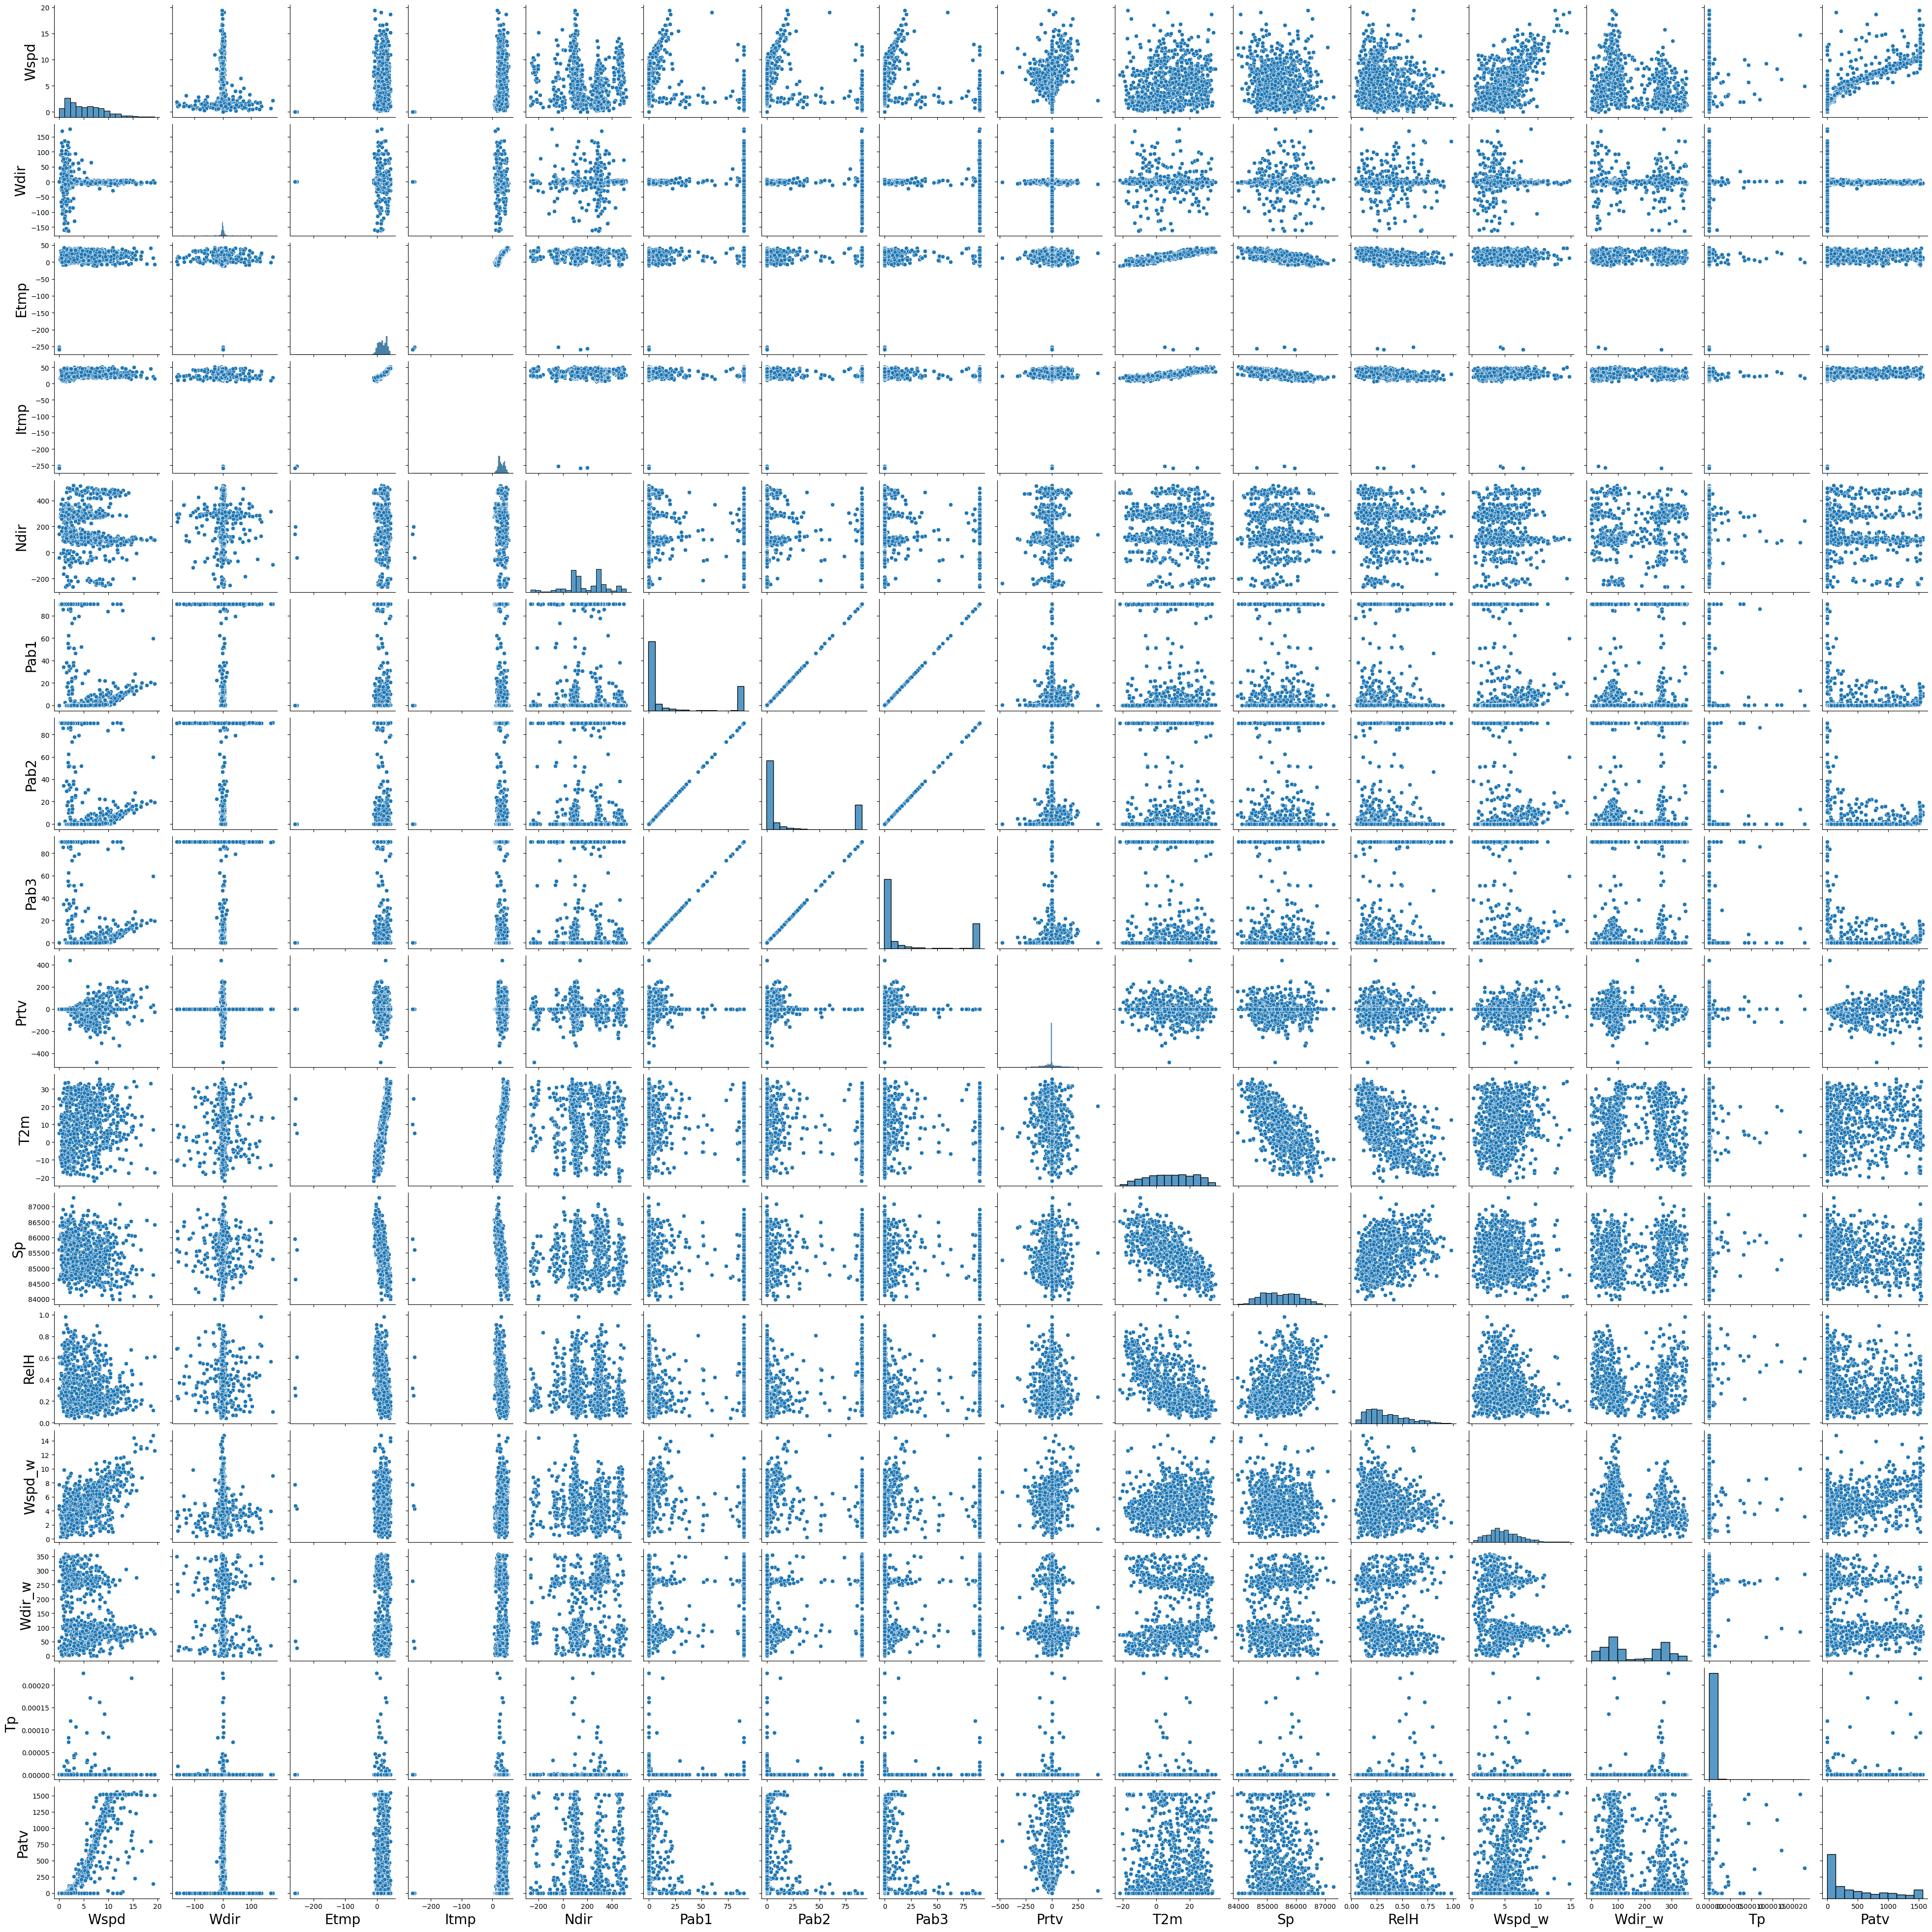

In [15]:
def plot_pairplot(
    original_df: pd.core.frame.DataFrame,
    turb_id: int,
    features: List[str],
    fraction: float = 0.01,
):
    """Creates a pairplot of the features.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        turb_id (int): Selected turbine ID
        features (List[str]): List of features to include in the plot.
        fraction (float): amount of data to plot, to reduce time.
    """
    data_single_turbine = original_df[original_df.TurbID == turb_id][features]
    data_single_turbine = data_single_turbine.sample(frac=fraction)
    with sns.plotting_context(rc={"axes.labelsize": 20}):
        sns.pairplot(data_single_turbine)
    plt.show()


turb_id = 6  # the id of the turbine
fraction = 0.01  # the fraction of the rows to include in the plot

plot_pairplot(top_turbines, turb_id, numerical_features, fraction)

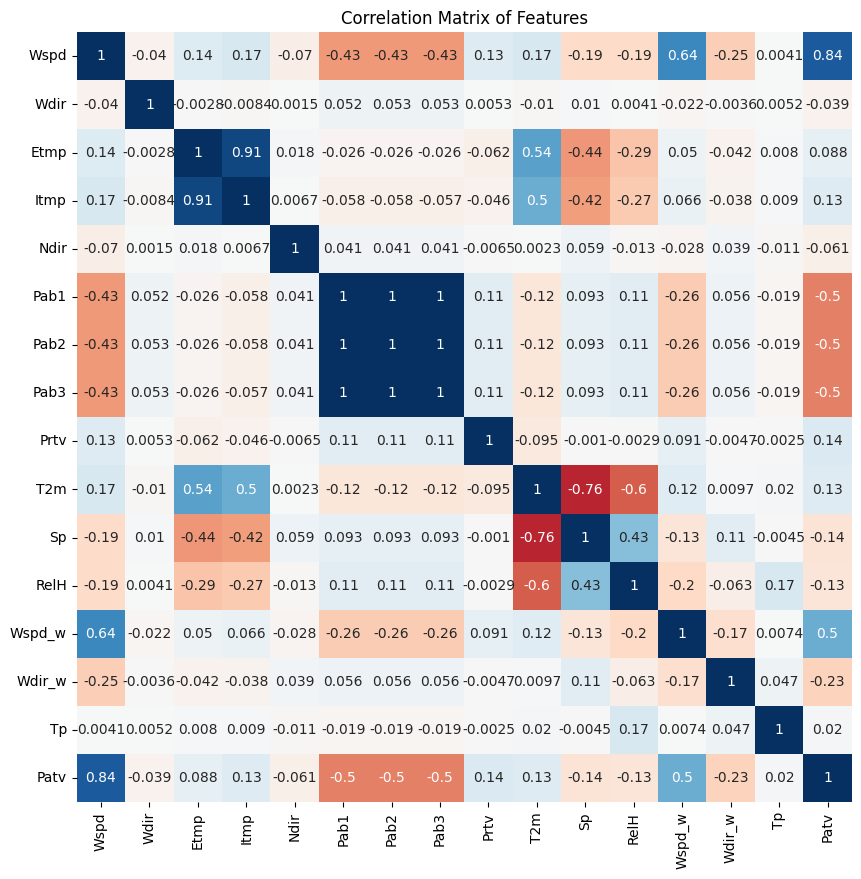

In [16]:
def correlation_matrix(data: pd.core.frame.DataFrame):
    """Plots correlation matrix for a given dataset.

    Args:
        data (pd.core.frame.DataFrame): The dataset used.
    """
    plt.figure(figsize=(10, 10))
    sns.heatmap(data.corr(), annot=True, cbar=False, cmap="RdBu", vmin=-1, vmax=1)
    plt.title("Correlation Matrix of Features")
    plt.show()


correlation_matrix(top_turbines[numerical_features])

In [17]:
def plot_time_series(df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive plots for the time series in the dataset.

    Args:
        df (pd.core.frame.DataFrame): The data used.
        features (List[str]): Features to include in the plot.
    """

    def plot_time_series(turbine, feature, date_range, fix_temps):
        data = df[df.TurbID == turbine]
        if fix_temps:
            min_etemp = data["Etmp"].quantile(0.01)
            data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
            data["Etmp"] = data["Etmp"].interpolate()
            min_itemp = data["Itmp"].quantile(0.01)
            data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
            data["Itmp"] = data["Itmp"].interpolate()

        data = data[data.Tmstamp > date_range[0]]
        data = data[data.Tmstamp < date_range[1]]
        plt.figure(figsize=(15, 5))
        plt.plot(data["Tmstamp"], data[feature], "-")
        plt.title(f"Time series of {feature}", fontsize=FONT_SIZE_TITLE)
        plt.ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        plt.xlabel(f"Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.show()

    turbine_selection = widgets.Dropdown(
        options=df.TurbID.unique(),
        value=df.TurbID.unique()[-1],
        description="Turbine ID",
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    start_date = pd.to_datetime("2020-05-01")
    end_date = pd.to_datetime("2020-12-31")

    dates = pd.date_range(start_date, end_date, freq="D")

    options = [(date.strftime("%b %d"), date) for date in dates]
    index = (0, len(options) - 1)

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description="Date (2020)",
        orientation="horizontal",
        layout={"width": "550px"},
    )

    fix_temps_button = widgets.Checkbox(
        value=False, description="Fix Temperatures", disabled=False
    )

    interact(
        plot_time_series,
        turbine=turbine_selection,
        feature=feature_selection,
        date_range=date_slider_selection,
        fix_temps=fix_temps_button,
    )


plot_time_series(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=9, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), …

In [18]:
def time_series_turbine_pair(original_df: pd.core.frame.DataFrame, features: List[str]):
    """Creates interactive plots for the time series for a pair of turbines in the dataset.

    Args:
        original_df (pd.core.frame.DataFrame): The data used.
        features (List[str]): Features to include in the plot.
    """

    def plot_time_series(turbine_1, turbine_2, feature, date_range, fix_temps):
        df = original_df
        if fix_temps:
            df_2 = original_df.copy(deep=True)

            min_etemp = df_2["Etmp (°C)"].quantile(0.01)
            df_2["Etmp (°C)"] = df_2["Etmp (°C)"].apply(
                lambda x: np.nan if x < min_etemp else x
            )
            df_2["Etmp (°C)"] = df_2["Etmp (°C)"].interpolate()
            min_itemp = df_2["Itmp (°C)"].quantile(0.01)
            df_2["Itmp (°C)"] = df_2["Itmp (°C)"].apply(
                lambda x: np.nan if x < min_itemp else x
            )
            df_2["Itmp (°C)"] = df_2["Itmp (°C)"].interpolate()
            df = df_2

        data_1 = df[df.TurbID == turbine_1]
        data_1 = data_1[data_1.Tmstamp > date_range[0]]
        data_1 = data_1[data_1.Tmstamp < date_range[1]]

        data_2 = df[df.TurbID == turbine_2]
        data_2 = data_2[data_2.Tmstamp > date_range[0]]
        data_2 = data_2[data_2.Tmstamp < date_range[1]]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))
        ax1.plot(data_1["Tmstamp"], data_1[feature], "-")
        ax1.set_title(
            f"Time series of {feature} for turbine {turbine_1}",
            fontsize=FONT_SIZE_TITLE,
        )
        ax2.plot(data_2["Tmstamp"], data_2[feature], "-", c="green")
        ax2.set_title(
            f"Time series of {feature} for turbine {turbine_2}",
            fontsize=FONT_SIZE_TITLE,
        )
        ax1.set_ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax2.set_ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax1.set_xlabel(f"Date", fontsize=FONT_SIZE_AXES)
        ax2.set_xlabel(f"Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.tight_layout()
        plt.show()

    turbine_selection_1 = widgets.Dropdown(
        options=original_df.TurbID.unique(),
        value=original_df.TurbID.unique()[-2],
        description="Turbine ID",
    )

    turbine_selection_2 = widgets.Dropdown(
        options=original_df.TurbID.unique(),
        value=original_df.TurbID.unique()[-1],
        description="Another Turbine ID",
        style={"description_width": "initial"},
    )

    feature_selection = widgets.Dropdown(
        options=features,
        description="Feature",
    )

    fix_temps_button = widgets.Checkbox(
        value=False, description="Fix Temperatures", disabled=False
    )

    dates = pd.date_range(datetime(2020, 5, 1), datetime(2020, 12, 31), freq="D")

    options = [(date.strftime("%b %d"), date) for date in dates]
    index = (0, len(options) - 1)

    date_slider_selection = widgets.SelectionRangeSlider(
        options=options,
        index=index,
        description="Date (2020)",
        orientation="horizontal",
        layout={"width": "550px"},
    )

    interact(
        plot_time_series,
        turbine_1=turbine_selection_1,
        turbine_2=turbine_selection_2,
        feature=feature_selection,
        date_range=date_slider_selection,
        fix_temps=fix_temps_button,
    )


time_series_turbine_pair(top_turbines, numerical_features)

interactive(children=(Dropdown(description='Turbine ID', index=8, options=(1, 3, 5, 6, 8, 9, 10, 11, 12, 26), …

### Unknown and Abnormal Values

Apart from missing values, there are other types of issues with the dataset.

`unknown`:
- if `Patv` ≤ 0 and `Wspd` > 2.5
- if `Pab1` > 89° or `Pab2` > 89° or `Pab3` > 89° 

`abnormal`:
- if `Ndir` < -720 or `Ndir` > 720
- if `Wdir` < -180 or `Wdir` > 180

In [19]:
def tag_abnormal_values(
    df: pd.core.frame.DataFrame, condition: pd.core.series.Series
) -> pd.core.frame.DataFrame:
    """Determines if a given record is an abnormal value.

    Args:
        df (pd.core.frame.DataFrame): The dataset used.
        condition (pd.core.series.Series): Series that includes if a record meets one of the conditions for being an abnormal value.

    Returns:
        pd.core.frame.DataFrame: Dataset with tagger abnormal values.
    """
    indexes = df[condition].index
    df.loc[indexes, "Include"] = False
    return df

In [20]:
# Initially include all rows
raw_data["Include"] = True

# Define conditions for abnormality
conditions = [
    np.isnan(raw_data.Patv),
    (raw_data.Pab1 > 89) | (raw_data.Pab2 > 89) | (raw_data.Pab3 > 89),
    (raw_data.Ndir < -720) | (raw_data.Ndir > 720),
    (raw_data.Wdir < -180) | (raw_data.Wdir > 180),
    (raw_data.Patv <= 0) & (raw_data.Wspd > 2.5),
]

# Exclude abnormal features
for condition in conditions:
    raw_data = tag_abnormal_values(raw_data, condition)

clean_data = raw_data[raw_data.Include].drop(["Include"], axis=1)
clean_data.head()

TurbID             Tmstamp   Wspd  Wdir  Etmp   Itmp    Ndir  Pab1  \
3077392       1 2020-01-01 00:10:00  10.44 -0.45  2.05  19.81  375.16  1.01   
3093504       2 2020-01-01 00:10:00  10.44 -0.45  2.05  19.81  375.16  1.01   
3109616       3 2020-01-01 00:10:00  10.44 -0.45  2.05  19.81  375.16  1.01   
3125728       4 2020-01-01 00:10:00  10.44 -0.45  2.05  19.81  375.16  1.01   
3141840       5 2020-01-01 00:10:00  10.44 -0.45  2.05  19.81  375.16  1.01   

         Pab2  Pab3  Prtv        T2m        Sp      RelH    Wspd_w     Wdir_w  \
3077392  1.01  1.01   9.1 -11.705597  85489.42  0.505227  6.280565  83.357327   
3093504  1.01  1.01   9.1 -11.705597  85489.42  0.505227  6.280565  83.357327   
3109616  1.01  1.01   9.1 -11.705597  85489.42  0.505227  6.280565  83.357327   
3125728  1.01  1.01   9.1 -11.705597  85489.42  0.505227  6.280565  83.357327   
3141840  1.01  1.01   9.1 -11.705597  85489.42  0.505227  6.280565  83.357327   

          Tp     Patv  
3077392  0.0  1503.05  
3093504  0.0  1503.05  
3109616  0.0  1503.05  
3125728  0.0  1503.05  
3141840  0.0  1503.05

### Feature Engineering

#### Blade Angles

Get rid of correlated Features Pab

In [21]:
def cut_pab_features(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Deletes redundant Pab features from dataset.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset used.

    Returns:
        pd.core.frame.DataFrame: The dataset without the redundant Pab features.
    """

    raw_data = raw_data.drop(["Pab2", "Pab3"], axis=1)
    raw_data = raw_data.rename(columns={"Pab1": "Pab"})

    return raw_data


clean_data = cut_pab_features(clean_data)

#### Angle Unit Change

There are 3 features (`Wdir`, `Ndir`, `Pab`) which are encoded in degrees. This is problematic because the model has no way of knowing that angles with very different values (such as 0° and 360°) are actually very similar (the same in this case) to each other. Thus transform them into `sine`/`cosine` representations.

In [22]:
def transform_angles(
    data: pd.core.frame.DataFrame, feature: str, drop_original: bool = True
):
    """Transform angles into their Sin/Cos encoding.

    Args:
        data (pd.core.frame.DataFrame): The dataset used.
        feature (str): Name of the angle feature.
        drop_original (bool, optional): Wheter to drop the original column from the dataset. Defaults to True.
    """
    rads = data[feature] * np.pi / 180

    data[f"{feature}Cos"] = np.cos(rads)
    data[f"{feature}Sin"] = np.sin(rads)

    if drop_original:
        data.drop(feature, axis=1, inplace=True)


for feature in ["Wdir_w", "Wdir", "Ndir", "Pab"]:
    transform_angles(clean_data, feature)

#### Temperature and Active Power

Both `Etmp` and `Itmp` have really negative values. In fact, these minimum values are very close to the absolute zero (-273.15 °C) which is most certainly an error. Use linear interpolation for the same.

Active power has negative values which doesn't make sense in the context of the problem at hand. The paper also addresses this issue by mentioning that all negative values should be treated as zero. 

In [23]:
def fix_temperatures(data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Replaces very low temperature values with linear interpolation.

    Args:
        data (pd.core.frame.DataFrame): The dataset.

    Returns:
        pd.core.frame.DataFrame: Dataset with fixed temperatures.
    """
    min_etemp = data["Etmp"].quantile(0.01)
    data["Etmp"] = data["Etmp"].apply(lambda x: np.nan if x < min_etemp else x)
    data["Etmp"] = data["Etmp"].interpolate()
    min_itemp = data["Itmp"].quantile(0.01)
    data["Itmp"] = data["Itmp"].apply(lambda x: np.nan if x < min_itemp else x)
    data["Itmp"] = data["Itmp"].interpolate()

    return data


clean_data = fix_temperatures(clean_data)
clean_data["Patv"] = clean_data["Patv"].apply(lambda x: max(0, x))

#### TOD Features

In [24]:
def generate_time_signals(raw_data: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    """Creates time signal features (time-of-day) for the data.

    Args:
        raw_data (pd.core.frame.DataFrame): The dataset uded.

    Returns:
        pd.core.frame.DataFrame: The dataset with the new features.
    """
    if "Day sin" in raw_data.columns:
        return raw_data

    date_time = pd.to_datetime(raw_data.Tmstamp, format="%Y-%m-%d %H:%M")
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    day = 24 * 60 * 60

    raw_data["Time-of-day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
    raw_data["Time-of-day cos"] = np.cos(timestamp_s * (2 * np.pi / day))

    return raw_data


clean_data = generate_time_signals(clean_data)

In [25]:
clean_data

TurbID             Tmstamp   Wspd  Etmp   Itmp   Prtv        T2m  \
3077392        1 2020-01-01 00:10:00  10.44  2.05  19.81   9.10 -11.705597   
3093504        2 2020-01-01 00:10:00  10.44  2.05  19.81   9.10 -11.705597   
3109616        3 2020-01-01 00:10:00  10.44  2.05  19.81   9.10 -11.705597   
3125728        4 2020-01-01 00:10:00  10.44  2.05  19.81   9.10 -11.705597   
3141840        5 2020-01-01 00:10:00  10.44  2.05  19.81   9.10 -11.705597   
...          ...                 ...    ...   ...    ...    ...        ...   
11203504     120 2021-12-31 23:50:00   2.46  1.55  10.56 -35.17 -12.468079   
11256065     121 2021-12-31 23:50:00   2.26 -1.51   7.38 -44.18 -12.468079   
11308626     122 2021-12-31 23:50:00   1.87 -1.11   7.60  -0.32 -12.468079   
10520211     129 2021-12-31 23:50:00   2.45  1.50   5.21  -0.30 -12.468079   
10625333     131 2021-12-31 23:50:00   3.30  1.43  16.92 -20.58 -12.468079   

                Sp      RelH    Wspd_w  ...  Wdir_wCos  Wdir_wSin   WdirCos  \
3077392   85489.42  0.505227  6.280565  ...   0.115677   0.993287  0.999969   
3093504   85489.42  0.505227  6.280565  ...   0.115677   0.993287  0.999969   
3109616   85489.42  0.505227  6.280565  ...   0.115677   0.993287  0.999969   
3125728   85489.42  0.505227  6.280565  ...   0.115677   0.993287  0.999969   
3141840   85489.42  0.505227  6.280565  ...   0.115677   0.993287  0.999969   
...            ...       ...       ...  ...        ...        ...       ...   
11203504  86241.92  0.577978  2.974639  ...   0.999980  -0.006366  0.998763   
11256065  86241.92  0.577978  2.974639  ...   0.999980  -0.006366  0.998565   
11308626  86241.92  0.577978  2.974639  ...   0.999980  -0.006366  0.999180   
10520211  86241.92  0.577978  2.974639  ...   0.999980  -0.006366  0.960585   
10625333  86241.92  0.577978  2.974639  ...   0.999980  -0.006366  0.998470   

           WdirSin   NdirCos   NdirSin    PabCos    PabSin  Time-of-day sin  \
3077392  -0.007854  0.965199  0.261515  0.999845  0.017627         0.043619   
3093504  -0.007854  0.965199  0.261515  0.999845  0.017627         0.043619   
3109616  -0.007854  0.965199  0.261515  0.999845  0.017627         0.043619   
3125728  -0.007854  0.965199  0.261515  0.999845  0.017627         0.043619   
3141840  -0.007854  0.965199  0.261515  0.999845  0.017627         0.043619   
...            ...       ...       ...       ...       ...              ...   
11203504  0.049721 -0.939752  0.341856  1.000000  0.000175        -0.043619   
11256065  0.053556  0.834175 -0.551500  1.000000  0.000175        -0.043619   
11308626  0.040481 -0.249197 -0.968453  0.742093  0.670297        -0.043619   
10520211  0.277985  0.601397 -0.798951  0.120483  0.992715        -0.043619   
10625333  0.055299 -0.304532 -0.952502  0.987824  0.155572        -0.043619   

          Time-of-day cos  
3077392          0.999048  
3093504          0.999048  
3109616          0.999048  
3125728          0.999048  
3141840          0.999048  
...                   ...  
11203504         0.999048  
11256065         0.999048  
11308626         0.999048  
10520211         0.999048  
10625333         0.999048  

[8703308 rows x 22 columns]

In [26]:
clean_data.columns

Index(['TurbID', 'Tmstamp', 'Wspd', 'Etmp', 'Itmp', 'Prtv', 'T2m', 'Sp',
       'RelH', 'Wspd_w', 'Tp', 'Patv', 'Wdir_wCos', 'Wdir_wSin', 'WdirCos',
       'WdirSin', 'NdirCos', 'NdirSin', 'PabCos', 'PabSin', 'Time-of-day sin',
       'Time-of-day cos'],
      dtype='object')

### Resample - Hourly, Single Turbine

In [27]:
def prepare_data(df: pd.core.frame.DataFrame, turb_id: int) -> pd.core.frame.DataFrame:
    """Pre-process data before feeding to neural networks for training.
    This includes:
    - Resampling to an hourly basis
    - Using data from a single turbine
    - Format datetime
    - Mask abnormal values
    - Re-order columns

    Args:
        df (pandas.core.frame.DataFrame): The curated data from the previous lab.
        turb_id (int): ID of the turbine to use.

    Returns:
        pandas.core.frame.DataFrame: Processed dataframe.
    """
    df = df[5::6]
    df = df[df.TurbID == turb_id]
    df = df.drop(["TurbID"], axis=1)
    df.index = pd.to_datetime(df.pop("Tmstamp"), format="%Y-%m-%d %H:%M")

    df = df[
        [
            "Wspd",
            "Etmp",
            "Itmp",
            "Prtv",
            "T2m",
            "Sp",
            "RelH",
            "Wspd_w",
            "Tp",
            "WdirCos",
            "WdirSin",
            "NdirCos",
            "NdirSin",
            "PabCos",
            "PabSin",
            "Time-of-day sin",
            "Time-of-day cos",
            "Wdir_wCos",
            "Wdir_wSin",
            "Patv",
        ]
    ]

    return df


turb_id = 6
data = prepare_data(clean_data, turb_id)
data.head(5)

Wspd  Etmp   Itmp  Prtv        T2m        Sp      RelH  \
Tmstamp                                                                        
2020-01-01 00:10:00  10.44  2.05  19.81   9.1 -11.705597  85489.42  0.505227   
2020-01-01 00:55:00  10.44  2.05  19.81   9.1 -11.705597  85489.42  0.505227   
2020-01-01 01:40:00  10.44  2.05  19.81   9.1 -11.705597  85489.42  0.505227   
2020-01-01 02:25:00  10.44  2.05  19.81   9.1 -11.705597  85489.42  0.505227   
2020-01-01 03:10:00  10.44  2.05  19.81   9.1 -11.705597  85489.42  0.505227   

                       Wspd_w   Tp   WdirCos   WdirSin   NdirCos   NdirSin  \
Tmstamp                                                                      
2020-01-01 00:10:00  6.280565  0.0  0.999969 -0.007854  0.965199  0.261515   
2020-01-01 00:55:00  6.280565  0.0  0.999969 -0.007854  0.965199  0.261515   
2020-01-01 01:40:00  6.280565  0.0  0.999969 -0.007854  0.965199  0.261515   
2020-01-01 02:25:00  6.280565  0.0  0.999969 -0.007854  0.965199  0.261515   
2020-01-01 03:10:00  6.280565  0.0  0.999969 -0.007854  0.965199  0.261515   

                       PabCos    PabSin  Time-of-day sin  Time-of-day cos  \
Tmstamp                                                                     
2020-01-01 00:10:00  0.999845  0.017627         0.043619         0.999048   
2020-01-01 00:55:00  0.999845  0.017627         0.237686         0.971342   
2020-01-01 01:40:00  0.999845  0.017627         0.422618         0.906308   
2020-01-01 02:25:00  0.999845  0.017627         0.591310         0.806445   
2020-01-01 03:10:00  0.999845  0.017627         0.737277         0.675590   

                     Wdir_wCos  Wdir_wSin     Patv  
Tmstamp                                             
2020-01-01 00:10:00   0.115677   0.993287  1503.05  
2020-01-01 00:55:00   0.115677   0.993287  1503.05  
2020-01-01 01:40:00   0.115677   0.993287  1503.05  
2020-01-01 02:25:00   0.115677   0.993287  1503.05  
2020-01-01 03:10:00   0.115677   0.993287  1503.05

### Split Data into Train, Validation and Test Sets

In [28]:
@dataclass
class DataSplits:
    """Class to encapsulate normalized/unnormalized train, val, test, splits."""

    train_data: pd.core.frame.DataFrame
    val_data: pd.core.frame.DataFrame
    test_data: pd.core.frame.DataFrame
    train_mean: pd.core.series.Series
    train_std: pd.core.series.Series
    train_df_unnormalized: pd.core.frame.DataFrame
    val_df_unnormalized: pd.core.frame.DataFrame
    test_df_unnormalized: pd.core.frame.DataFrame


def normalize_data(
    train_data: pd.core.frame.DataFrame,
    val_data: pd.core.frame.DataFrame,
    test_data: pd.core.frame.DataFrame,
) -> Tuple[
    np.ndarray, np.ndarray, np.ndarray, pd.core.series.Series, pd.core.series.Series
]:
    """Normalizes train, val and test splits.

    Args:
        train_data (pd.core.frame.DataFrame): Train split.
        val_data (pd.core.frame.DataFrame): Validation split.
        test_data (pd.core.frame.DataFrame): Test split.

    Returns:
        tuple: Normalized splits with training mean and standard deviation.
    """
    train_mean = train_data.mean()
    train_std = train_data.std()

    train_data = (train_data - train_mean) / train_std
    val_data = (val_data - train_mean) / train_std
    test_data = (test_data - train_mean) / train_std

    return train_data, val_data, test_data, train_mean, train_std


def train_val_test_split(df: pd.core.frame.DataFrame) -> DataSplits:
    """Splits a dataframe into train, val and test.

    Args:
        df (pd.core.frame.DataFrame): The data to split.

    Returns:
        data_splits (DataSplits): An instance that encapsulates normalized/unnormalized splits.
    """
    n = len(df)
    train_df = df[0 : int(n * 0.7)]
    val_df = df[int(n * 0.7) : int(n * 0.9)]
    test_df = df[int(n * 0.9) :]

    train_df_un = train_df.copy(deep=True)
    val_df_un = val_df.copy(deep=True)
    test_df_un = test_df.copy(deep=True)

    train_df_un = train_df_un.mask(train_df_un.Patv == -1, np.nan)
    val_df_un = val_df_un.mask(val_df_un.Patv == -1, np.nan)
    test_df_un = test_df_un.mask(test_df_un.Patv == -1, np.nan)

    train_df, val_df, test_df, train_mn, train_st = normalize_data(
        train_df, val_df, test_df
    )

    ds = DataSplits(
        train_data=train_df,
        val_data=val_df,
        test_data=test_df,
        train_mean=train_mn,
        train_std=train_st,
        train_df_unnormalized=train_df_un,
        val_df_unnormalized=val_df_un,
        test_df_unnormalized=test_df_un,
    )

    return ds

In [29]:
data_splits = train_val_test_split(data)

print("training, validation and testing splits successfully created and normalized.")

training, validation and testing splits successfully created and normalized.


## Baseline

In [30]:
def compute_metrics(
    true_series: np.ndarray, forecast: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Computes MSE and MAE between two time series.

    Args:
        true_series (np.ndarray): True values.
        forecast (np.ndarray): Forecasts.

    Returns:
        tuple: MSE and MAE metrics.
    """

    mse = tf.keras.losses.MSE(true_series, forecast).numpy()
    mae = tf.keras.losses.MAE(true_series, forecast).numpy()

    return mse, mae

In [31]:
class WindowGenerator:
    """Class that handles all of the windowing and plotting logic for time series."""

    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df,
        val_df,
        test_df,
        label_columns=["Patv"],
    ):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels

    def plot(self, model=None, plot_col="Patv", max_subplots=1):
        inputs, labels = self.example
        plt.figure(figsize=(20, 6))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n + 1)
            plt.title(
                "Inputs (past) vs Labels (future predictions)", fontsize=FONT_SIZE_TITLE
            )
            plt.ylabel(f"{plot_col} (normalized)", fontsize=FONT_SIZE_AXES)
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                color="green",
                linestyle="--",
                label="Inputs",
                marker="o",
                markersize=10,
                zorder=-10,
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(
                self.label_indices,
                labels[n, :, label_col_index],
                color="orange",
                linestyle="--",
                label="Labels",
                markersize=10,
                marker="o",
            )
            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices,
                    predictions[n, :, label_col_index],
                    marker="*",
                    edgecolors="k",
                    label="Predictions",
                    c="pink",
                    s=64,
                )
            plt.legend(fontsize=FONT_SIZE_TICKS)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        plt.xlabel("Timestep", fontsize=FONT_SIZE_AXES)

    def plot_long(
        self,
        model,
        data_splits,
        plot_col="Patv",
        time_steps_future=1,
        baseline_mae=None,
    ):
        train_mean, train_std = data_splits.train_mean, data_splits.train_std
        self.test_size = len(self.test_df)
        self.test_data = self.make_test_dataset(self.test_df, self.test_size)

        inputs, labels = next(iter(self.test_data))

        plt.figure(figsize=(20, 6))
        plot_col_index = self.column_indices[plot_col]

        plt.ylabel(f"{plot_col} (kW)", fontsize=FONT_SIZE_AXES)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        labels = (labels * train_std.Patv) + train_mean.Patv

        upper = 24 - (time_steps_future - 1)
        lower = self.label_indices[-1] - upper
        self.label_indices_long = self.test_df.index[lower:-upper]

        plt.plot(
            self.label_indices_long[:],
            labels[:, time_steps_future - 1, label_col_index][:],
            label="Labels",
            c="green",
        )

        if model is not None:
            predictions = model(inputs)
            predictions = (predictions * train_std.Patv) + train_mean.Patv
            predictions_for_timestep = predictions[
                :, time_steps_future - 1, label_col_index
            ][:]
            predictions_for_timestep = tf.nn.relu(predictions_for_timestep).numpy()
            plt.plot(
                self.label_indices_long[:],
                predictions_for_timestep,
                label="Predictions",
                c="orange",
                linewidth=3,
            )
            plt.legend(fontsize=FONT_SIZE_TICKS)
            _, mae = compute_metrics(
                labels[:, time_steps_future - 1, label_col_index][:],
                predictions_for_timestep,
            )

            if baseline_mae is None:
                baseline_mae = mae

            print(
                f"\nMean Absolute Error (kW): {mae:.2f} for forecast.\n\nImprovement over random baseline: {100*((baseline_mae -mae)/baseline_mae):.2f}%"
            )
        plt.title("Predictions vs Real Values for Test Split", fontsize=FONT_SIZE_TITLE)
        plt.xlabel("Date", fontsize=FONT_SIZE_AXES)
        plt.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)
        return mae

    def make_test_dataset(self, data, bs):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=False,
            batch_size=bs,
        )

        ds = ds.map(self.split_window)

        return ds

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        result = getattr(self, "_example", None)
        if result is None:
            result = next(iter(self.train))
            self._example = result
        return result


def generate_window(
    train_df: pd.core.frame.DataFrame,
    val_df: pd.core.frame.DataFrame,
    test_df: pd.core.frame.DataFrame,
    days_in_past: int,
    width: int = 24,
) -> WindowGenerator:
    """Creates a windowed dataset given the train, val, test splits and the number of days into the past.

    Args:
        train_df (pd.core.frame.DataFrame): Train split.
        val_df (pd.core.frame.DataFrame): Val Split.
        test_df (pd.core.frame.DataFrame): Test split.
        days_in_past (int): How many days into the past will be used to predict the next 24 hours.

    Returns:
        WindowGenerator: The windowed dataset.
    """
    OUT_STEPS = 24
    multi_window = WindowGenerator(
        input_width=width * days_in_past,
        label_width=OUT_STEPS,
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        shift=OUT_STEPS,
    )
    return multi_window

### Method 1 - Uniformly Random Forecast


Mean Absolute Error (kW): 468.37 for forecast.

Improvement over random baseline: 0.00%


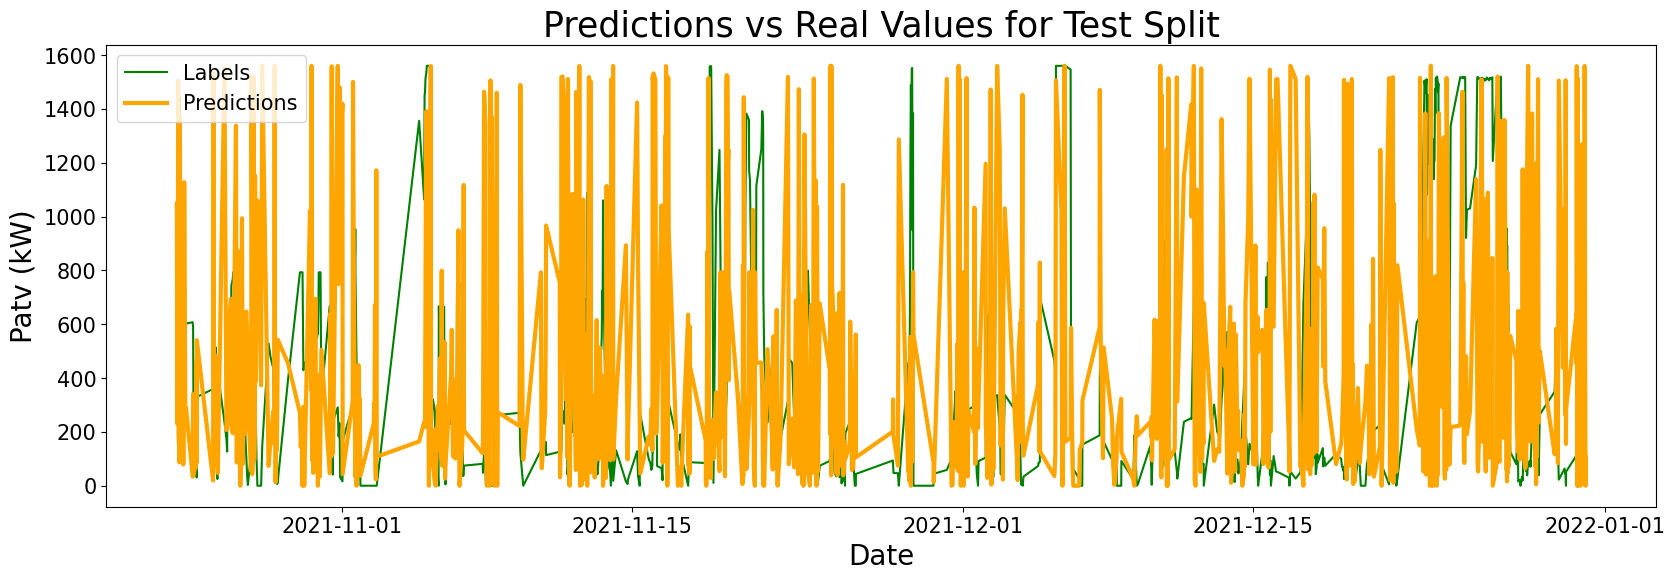

In [32]:
def random_forecast(
    data_splits: DataSplits, n_days: int = 1
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Generates a random forecast for a time window.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int, optional): Period from which to draw the random values. Defaults to 1.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )

    random_window = generate_window(train_data, val_data, test_data, n_days)

    class randomBaseline(tf.keras.Model):
        def call(self, inputs):
            tf.random.set_seed(424)
            np.random.seed(424)
            random.seed(424)
            stacked = tf.random.shuffle(inputs)

            return stacked[:, :, -1:]

    random_baseline = randomBaseline()
    random_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return random_window, random_baseline


random_window, random_baseline = random_forecast(data_splits)
random_baseline_mae = random_window.plot_long(random_baseline, data_splits)

### Method 2 - Replicate Yesterday's Behaviour

Window size throughout the notebook is kept at 24 hrs (1 day) for consistenvy of analysis.

In [33]:
def repeat_forecast(
    data_splits: DataSplits, shift: int = 24
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Performs a repeated forecast logic.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int): Period to repeat.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )
    repeat_window = generate_window(train_data, val_data, test_data, 1, shift)

    class RepeatBaseline(tf.keras.Model):
        def call(self, inputs):
            return inputs[:, :, -1:]

    repeat_baseline = RepeatBaseline()
    repeat_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return repeat_window, repeat_baseline


def interact_repeat_forecast(data_splits: DataSplits, baseline_mae: float) -> None:
    """Plot an interactive visualization of predictions vs true values.

    Args:
        func (Callable): Function to close over. Should be the plot_long method from the WindowGenerator instance.
        model (tf.keras.Model): The trained model.
        data_splits (DataSplits): The data used.
        baseline_mae (float): MAE of baseline to compare against.
    """

    def _plot(shift):
        repeat_window, repeat_baseline = repeat_forecast(data_splits, shift=shift)
        _ = repeat_window.plot_long(
            repeat_baseline, data_splits, baseline_mae=baseline_mae
        )

    shift_selection = widgets.IntSlider(
        value=24,
        min=1,
        max=24,
        step=1,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, shift=shift_selection)


interact_repeat_forecast(data_splits, baseline_mae=random_baseline_mae)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Method 3 - Moving Average Forecasts

In [34]:
def moving_avg_forecast(
    data_splits: DataSplits, n_days: int
) -> Tuple[WindowGenerator, tf.keras.Model]:
    """Performs a moving average forecast logic.

    Args:
        data_splits (DataSplits): The data to be used.
        n_days (int): Period to repeat.

    Returns:
        tuple: The windowed dataset and the model that handles the forecasting logic.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )
    moving_avg_window = generate_window(train_data, val_data, test_data, n_days)

    class avgBaseline(tf.keras.Model):
        def call(self, inputs):
            m = tf.math.reduce_mean(inputs, axis=1)
            stacked = tf.stack([m for _ in range(inputs.shape[1])], axis=1)

            return stacked[:, :, -1:]

    moving_avg_baseline = avgBaseline()
    moving_avg_baseline.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanAbsoluteError()],
    )

    return moving_avg_window, moving_avg_baseline


def prediction_plot(
    func: Callable, model: tf.keras.Model, data_splits: DataSplits, baseline_mae: float
) -> None:
    """Plot an interactive visualization of predictions vs true values.

    Args:
        func (Callable): Function to close over. Should be the plot_long method from the WindowGenerator instance.
        model (tf.keras.Model): The trained model.
        data_splits (DataSplits): The data used.
        baseline_mae (float): MAE of baseline to compare against.
    """

    def _plot(time_steps_future):
        mae = func(
            model,
            data_splits,
            time_steps_future=time_steps_future,
            baseline_mae=baseline_mae,
        )

    time_steps_future_selection = widgets.IntSlider(
        value=24,
        min=1,
        max=24,
        step=1,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, time_steps_future=time_steps_future_selection)


moving_avg_window, moving_avg_baseline = moving_avg_forecast(data_splits, n_days=1)
prediction_plot(
    moving_avg_window.plot_long,
    moving_avg_baseline,
    data_splits,
    baseline_mae=random_baseline_mae,
)

interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

## Initial Approach

CNN-LSTM Model for Time Series Prediction

Note: First check if validation and test splits are correct

In [35]:
def plot_time_series(data_splits: DataSplits) -> None:
    """Plots time series of active power vs the other features.

    Args:
        data_splits (DataSplits): Turbine data.
    """
    train_df, val_df, test_df = (
        data_splits.train_df_unnormalized,
        data_splits.val_df_unnormalized,
        data_splits.test_df_unnormalized,
    )

    def plot_time_series(feature):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
        ax1.plot(train_df["Patv"], color="blue", label="training")
        ax1.plot(val_df["Patv"], color="green", label="validation")
        ax1.plot(test_df["Patv"], color="red", label="test")
        ax1.set_title("Time series of Patv (target)", fontsize=FONT_SIZE_TITLE)
        ax1.set_ylabel("Active Power (kW)", fontsize=FONT_SIZE_AXES)
        ax1.set_xlabel("Date", fontsize=FONT_SIZE_AXES)
        ax1.legend(fontsize=15)
        ax1.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        ax2.plot(train_df[feature], color="blue", label="training")
        ax2.plot(val_df[feature], color="green", label="validation")
        ax2.plot(test_df[feature], color="red", label="test")
        ax2.set_title(f"Time series of {feature} (predictor)", fontsize=FONT_SIZE_TITLE)
        ax2.set_ylabel(f"{feature}", fontsize=FONT_SIZE_AXES)
        ax2.set_xlabel("Date", fontsize=FONT_SIZE_AXES)
        ax2.legend(fontsize=15)
        ax2.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

        plt.tight_layout()
        plt.show()

    feature_selection = widgets.Dropdown(
        options=[f for f in list(train_df.columns) if f != "Patv"],
        description="Feature",
    )

    interact(plot_time_series, feature=feature_selection)


plot_time_series(data_splits)

interactive(children=(Dropdown(description='Feature', options=('Wspd', 'Etmp', 'Itmp', 'Prtv', 'T2m', 'Sp', 'R…

As we see the chosen turbine was inactive during the time of COVID. Now let us visualise our windows for forecast.

In [36]:
def window_plot(data_splits: DataSplits) -> None:
    """Creates an interactive plots to show how the data is windowed depending on the number of days into the past that are used to forecast the next 24 hours.

    Args:
        data_splits (DataSplits): Data used.
    """
    train_data, val_data, test_data = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
    )

    def _plot(time_steps_past):
        window = generate_window(train_data, val_data, test_data, time_steps_past)
        window.plot()

    time_steps_past_selection = widgets.IntSlider(
        value=1,
        min=1,
        max=14,
        step=1,
        description="Days before",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, time_steps_past=time_steps_past_selection)


window_plot(data_splits)

interactive(children=(IntSlider(value=1, continuous_update=False, description='Days before', layout=Layout(wid…

### Method 1 - Model uses only Target Variables History

In [37]:
def create_model(num_features: int, days_in_past: int) -> tf.keras.Model:
    """Creates a Conv-LSTM model for time series prediction.

    Args:
        num_features (int): Number of features used for prediction.
        days_in_past (int): Number of days into the past to predict next 24 hours.

    Returns:
        tf.keras.Model: The uncompiled model.
    """
    CONV_WIDTH = 3
    OUT_STEPS = 24

    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(days_in_past * 24, num_features)),
            tf.keras.layers.Masking(mask_value=-1.0),
            tf.keras.layers.Conv1D(256, activation="relu", kernel_size=(CONV_WIDTH)),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=True)
            ),
            tf.keras.layers.Bidirectional(
                tf.keras.layers.LSTM(32, return_sequences=False)
            ),
            tf.keras.layers.Dense(
                OUT_STEPS * 1, kernel_initializer=tf.initializers.zeros()
            ),
            tf.keras.layers.Reshape([OUT_STEPS, 1]),
        ]
    )

    return model


def compile_and_fit(
    model: tf.keras.Model, window: WindowGenerator, patience: int = 2
) -> tf.keras.callbacks.History:
    """Compiles and trains a model given a patience threshold.

    Args:
        model (tf.keras.Model): The model to train.
        window (WindowGenerator): The windowed data.
        patience (int, optional): Patience threshold to stop training. Defaults to 2.

    Returns:
        tf.keras.callbacks.History: The training history.
    """
    EPOCHS = 20

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, mode="min"
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(),
    )

    tf.random.set_seed(432)
    np.random.seed(432)
    random.seed(432)

    history = model.fit(
        window.train,
        epochs=EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
    )

    if len(history.epoch) < EPOCHS:
        print(
            "\nTraining stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps."
        )

    return history


def train_conv_lstm_model(
    data: pd.core.frame.DataFrame, features: List[str], days_in_past: int
) -> Tuple[WindowGenerator, tf.keras.Model, DataSplits]:
    """Trains the Conv-LSTM model for time series prediction.

    Args:
        data (pd.core.frame.DataFrame): The dataframe to be used.
        data (list[str]): The features to use for forecasting.
        days_in_past (int): How many days in the past to use to forecast the next 24 hours.

    Returns:
        tuple: The windowed dataset, the model that handles the forecasting logic and the data used.
    """
    data_splits = train_val_test_split(data[features])

    train_data, val_data, test_data, train_mean, train_std = (
        data_splits.train_data,
        data_splits.val_data,
        data_splits.test_data,
        data_splits.train_mean,
        data_splits.train_std,
    )

    window = generate_window(train_data, val_data, test_data, days_in_past)
    num_features = window.train_df.shape[1]

    model = create_model(num_features, days_in_past)
    history = compile_and_fit(model, window)

    return window, model, data_splits

In [38]:
features = ["Patv"]
window, model, _data_splits = train_conv_lstm_model(data, features, days_in_past=1)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

Epoch 1/20


/Users/kartik/miniforge3/envs/MEMPL/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 102ms/step - loss: 0.9064 - val_loss: 0.8019
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 0.8488 - val_loss: 0.7993
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - loss: 0.8422 - val_loss: 0.8102
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - loss: 0.8340 - val_loss: 0.8162

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Method 2 - Model uses all Feature variables' History

In [39]:
features = list(data.columns)
window, model, _data_splits = train_conv_lstm_model(data, features, days_in_past=1)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/Users/kartik/miniforge3/envs/MEMPL/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.8909 - val_loss: 0.8349
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.7098 - val_loss: 0.9868
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 102ms/step - loss: 0.5648 - val_loss: 0.9827

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Method 3 - Use "Perfect" Wind-Speed Forecasts (ERA-5) for Predictions

In [40]:
def add_wind_speed_forecasts(
    df: pd.core.frame.DataFrame, add_noise=False
) -> pd.core.frame.DataFrame:
    """Creates syntethic wind speed forecasts. The more into the future, the more noise these have.

    Args:
        df (pd.core.frame.DataFrame): Dataframe with data from turbine.
        periods (list, optional): Periods for which to create the forecast. Defaults to [*range(1, 30, 1)].

    Returns:
        pd.core.frame.DataFrame: The new dataframe with the synth forecasts.
    """

    df_2 = df.copy(deep=True)
    # Periods for which to create the forecast.
    periods = [*range(1, 30, 1)]

    for period in periods:

        if add_noise == "linearly_increasing":
            np.random.seed(8752)
            noise_level = 0.2 * period
            noise = np.random.randn(len(df)) * noise_level

        elif add_noise == "mimic_real_forecast":
            np.random.seed(8752)
            noise_level = 2 + 0.05 * period
            noise = np.random.randn(len(df)) * noise_level
        else:
            noise = 0

        padding_slice = df_2["Wspd_w"][-period:].to_numpy()
        values = np.concatenate((df_2["Wspd_w"][period:].values, padding_slice)) + noise

        df_2[f"fc-{period}h"] = values

    return df_2

In [41]:
# Create a new dataframe with the perfect forecasts
data_with_perfect_wspd_forecasts = add_wind_speed_forecasts(data)
features = list(data_with_perfect_wspd_forecasts.columns)
window, model, _data_splits = train_conv_lstm_model(
    data_with_perfect_wspd_forecasts, features, days_in_past=1
)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/Users/kartik/miniforge3/envs/MEMPL/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_2' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 104ms/step - loss: 0.7370 - val_loss: 0.5881
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 0.4670 - val_loss: 0.6884
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.3626 - val_loss: 0.6663

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…

### Method 4 - Use "noisy" Wind-Speed Forecasts (ERA-5) for Realistic Predictions

For exploration of what kind of noise we need to add, use open weather forecast data for 3 different cities since the dataset has not released where the data is from.

In [42]:
def load_weather_forecast() -> Dict[str, Dict[List[datetime], List[float]]]:
    """Loads the wind data and forecast for three locations and returns it in a form of dictionary."""
    with open(OPEN_WEATHER_FORECASTS, "rb") as f:
        weather_forecasts = pickle.load(f)
    return weather_forecasts


def prepare_wind_data(
    dates0: List[datetime],
    dates1: List[datetime],
    winds0: List[float],
    winds1: List[float],
    min_bound: Optional[str] = None,
    max_bound: Optional[str] = None,
) -> Tuple[List[datetime], List[datetime], List[float], List[float]]:
    """Takes in two datasets of wind data.
    Finds the data points that appear in both datasets (at the same time) and are between the specified time bounds.

    Args:
        dates0 (list): list of dates for the first dataset
        dates1 (list): list of dates for the second dataset
        winds0 (list): list of wind speed for the first dataset (corresponding to dates0)
        winds1 (list): list of wind speed for the second dataset (corresponding to dates1)
        min_bound (datetime): minimum bound for plotting
        max_bound (datetime): maximum bound for plotting
    """
    winds0_overlap = []
    winds1_overlap = []
    dates0_overlap = []
    dates1_overlap = []

    # Only take the dates that are in both datasets and within the limits if specified
    for date, wind in zip(dates0, winds0):
        if (
            date in dates1
            and (min_bound is None or date > min_bound)
            and (max_bound is None or date < max_bound)
        ):
            winds0_overlap.append(wind)
            dates0_overlap.append(date)
    for date, wind in zip(dates1, winds1):
        if (
            date in dates0
            and (min_bound is None or date > min_bound)
            and (max_bound is None or date < max_bound)
        ):
            winds1_overlap.append(wind)
            dates1_overlap.append(date)

    return dates0_overlap, dates1_overlap, winds0_overlap, winds1_overlap


def plot_forecast(
    weather_forecasts: Dict[str, Dict[List[datetime], List[float]]]
) -> None:
    """Creates an interactive plot of true values vs forecasts for the wind data.

    Args:
        weather_forecasts (dict): History of weather and weather forecasts.
    """

    def _plot(city, time_steps_future):
        format_timestamp = "%Y-%m-%d %H:%M:%S"

        weather_forecast = weather_forecasts[city]

        dates_real, winds_real = weather_forecast[0]
        dates_real = [datetime.strptime(i, format_timestamp) for i in dates_real]
        dates_forecast, winds_forecast = weather_forecast[time_steps_future]
        dates_forecast = [
            datetime.strptime(i, format_timestamp) for i in dates_forecast
        ]

        # Set the min and max date for plotting, so it always plots the same
        min_date = datetime.strptime("2022-11-16 18:00:00", format_timestamp)
        max_date = datetime.strptime("2023-01-11 15:00:00", format_timestamp)

        # Find the overlap of the data and limit it to the plotting range
        dates_real, dates_forecast, winds_real, winds_forecast = prepare_wind_data(
            dates_real, dates_forecast, winds_real, winds_forecast, min_date, max_date
        )

        fig, ax = plt.subplots(figsize=(20, 6))
        ax.plot(dates_real, winds_real, label="Actual windspeed")
        ax.plot(
            dates_forecast,
            winds_forecast,
            label=f"Forecasted windspeed {time_steps_future} Hours in the Future",
        )
        ax.set_title(
            f"History of Actual vs Forecasted Windspeed in {city}", fontsize=25
        )
        ax.set_ylabel("Wind Speed (m/s)", fontsize=20)
        ax.set_xlabel("Date", fontsize=20)
        ax.tick_params(axis="both", labelsize=15)
        ax.legend(fontsize=15)

        mae = metrics.mean_absolute_error(winds_real, winds_forecast)
        print(f"\nMean Absolute Error (m/s): {mae:.2f} for forecast\n")

    city_selection = widgets.Dropdown(
        options=weather_forecasts.keys(),
        description="City",
    )
    time_steps_future_selection = widgets.IntSlider(
        value=1,
        min=3,
        max=120,
        step=3,
        description="Hours into future",
        disabled=False,
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format="d",
        layout={"width": "500px"},
        style={"description_width": "initial"},
    )

    interact(_plot, city=city_selection, time_steps_future=time_steps_future_selection)


weather_forecasts = load_weather_forecast()
plot_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

In [43]:
def plot_mae_forecast(
    weather_forecasts: Dict[str, Dict[List[datetime], List[float]]]
) -> None:
    """Creates an interactive plot MAE of wind forecasts.

    Args:
        weather_forecasts (dict): Weather and weather forecast data.
    """

    def _plot(city):
        weather_forecast = weather_forecasts[city]

        times = sorted(weather_forecast.keys())[1::]
        maes = []

        dates_real, winds_real = weather_forecast[0]
        for time in times:
            dates_forecast, winds_forecast = weather_forecast[time]
            dates_real, dates_forecast, winds_real, winds_forecast = prepare_wind_data(
                dates_real, dates_forecast, winds_real, winds_forecast
            )
            mae = metrics.mean_absolute_error(winds_real, winds_forecast)
            maes.append(mae)

        fig, ax = plt.subplots(figsize=(20, 6))
        ax.plot(times, maes, marker="*")
        ax.set_title(
            "Mean Absolute Error of Actual vs Predicted Wind Speed",
            fontsize=FONT_SIZE_TITLE,
        )
        ax.set_ylabel("Mean Absolute Error (m/s)", fontsize=FONT_SIZE_AXES)
        ax.set_xlabel("Hours into the future", fontsize=FONT_SIZE_AXES)
        ax.tick_params(axis="both", labelsize=FONT_SIZE_TICKS)

    city_selection = widgets.Dropdown(
        options=weather_forecasts.keys(),
        description="City",
    )

    interact(_plot, city=city_selection)


plot_mae_forecast(weather_forecasts)

interactive(children=(Dropdown(description='City', options=('Geelong, Australia', 'Porto Alegre, Brazil', 'Pit…

Clearly, there is a degradation in the forecasts which increases with time. Now, train the model with different types of losses.

In [44]:
data_with_wspd_forecasts = add_wind_speed_forecasts(
    data, add_noise="mimic_real_forecast"
)
features = list(data_with_wspd_forecasts.columns)
window, model, _data_splits = train_conv_lstm_model(
    data_with_wspd_forecasts, features, days_in_past=1
)
prediction_plot(window.plot_long, model, _data_splits, baseline_mae=random_baseline_mae)

/Users/kartik/miniforge3/envs/MEMPL/lib/python3.11/site-packages/keras/src/layers/layer.py:932: UserWarning: Layer 'conv1d_3' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - loss: 0.7671 - val_loss: 0.6296
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.5019 - val_loss: 0.6707
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - loss: 0.3971 - val_loss: 0.6830

Training stopped early to prevent overfitting, as the validation loss is increasing for two consecutive steps.


interactive(children=(IntSlider(value=24, continuous_update=False, description='Hours into future', layout=Lay…